<div class="alert alert-warning">
    
<b>Disclaimer:</b> 
    
The main objective of the <i>Jupyter</i> notebooks is to show how to use the models of the <i>QENS library</i> by
    
- building a fitting model: composition of models, convolution with a resolution function  
- setting and running the fit  
- extracting and displaying information about the results  

These steps have a minimizer-dependent syntax. That's one of the reasons why different minimizers have been used in the notebooks provided as examples.  
But, the initial guessed parameters might not be optimal, resulting in a poor fit of the reference data.

</div> 

# Two Lorentzian &lowast; resolution with lmfit

## Introduction

<div class="alert alert-info">
    
The objective of this notebook is to show how to use one of the models of 
the <a href="https://github.com/QENSlibrary/QENSmodels">QENSlibrary</a>, <b>Lorentzian</b>, to perform some fits.
<a href="https://lmfit.github.io/lmfit-py/">lmfit</a> is used for fitting.
</div>

The following example uses the data from IRIS:
- workspace_index=0, file: `irs26176_graphite002_red.nxs`  
- related instrument resolution data `irs26173_graphite002_res.nxs`   

The ISIS sample datasets can be downloaded from [Mantid's website](http://download.mantidproject.org/).
The data used for this example are in the sample datafile: `data_2lorentzians.dat` and the instrument resolution datafile `irf_iris.dat`, respectively.

This example is based on a [Mantid "Fitting QENS Peaks" tutorial](https://www.mantidproject.org/Fitting_QENS_Peaks).

The implementation with `lmfit` is based on https://lmfit.github.io/lmfit-py/model.html

This example requires an additional Python module `scipy.interpolate` to interpolate the tabulated data of the instrument resolution.

### Physical units
For information about unit conversion, please refer to the jupyter notebook called `Convert_units.ipynb` in the `tools` folder.

The dictionary of units defined in the cell below specify the units of the refined parameters adapted to the convention used in the experimental datafile.

In [1]:
# Units of parameters for selected QENS model and experimental data
dict_physical_units = {'omega': "meV", 
                       'q': "1/Angstrom", 
                       'hwhm': "meV", 
                       'scale': "unit_of_signal.meV",
                       'center': "meV"}

## Importing the required librairies

In [2]:
from __future__ import print_function
import numpy as np

import matplotlib.pyplot as plt

# for interactivity (plots, buttons...)
import ipywidgets

from lmfit import Model, CompositeModel
from scipy.interpolate import interp1d

import QENSmodels

path_to_data = './data/'

## Importing the reference data

In [3]:
# Create model - 2 lorentzians convoluted with instrument resolution - 6 parameters
# Step 1 load instrument resolution data
irf_iris = np.loadtxt(path_to_data + 'irf_iris.dat')
x_irf = irf_iris[:, 0]
y_irf = irf_iris[:, 1]

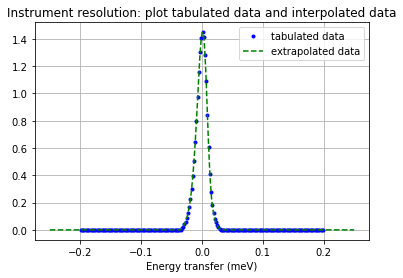

In [4]:
# Step 2: create function for instrument resolution data (cubic interpolation between tabulated data points)
f = interp1d(x_irf, y_irf, kind='cubic', bounds_error=False, fill_value='extrapolate')

def irf_gate(x):
    """ Function defined from the interpolation of instrument resolution data 
    Used to define fitting model and plot """ 
    return f(x)

# plot tabulated data and interpolated data
xx = np.linspace(-.25, .25, 500)

fig0, ax0 = plt.subplots()
ax0.plot(x_irf, y_irf, 'b.', label='tabulated data')
ax0.plot(xx, irf_gate(xx), 'g--', label='extrapolated data')
ax0.legend()
ax0.set(xlabel='Energy transfer (meV)', title='Instrument resolution: plot tabulated data and interpolated data')
ax0.grid();

## Setting and fitting

In [5]:
# Step 3: create "double lorentzian" profile
def model_2lorentzians(x, scale1, center1, hwhm1, scale2, center2, hwhm2):
    return QENSmodels.lorentzian(x, scale1, center1, hwhm1) + QENSmodels.lorentzian(x, scale2, center2, hwhm2)

In [6]:
# Step 4: create convolution function 
# code from https://lmfit.github.io/lmfit-py/model.html

def convolve(arr, kernel):
    # simple convolution of two arrays
    npts = min(len(arr), len(kernel))
    pad  = np.ones(npts)
    tmp  = np.concatenate((pad*arr[0], arr, pad*arr[-1]))
    
    out  = np.convolve(tmp, kernel, mode='valid')
    noff = int((len(out) - npts)/2)
    return out[noff:noff+npts]

In [7]:
# Create model for the fit
gmodel = CompositeModel(Model(irf_gate), Model(model_2lorentzians), convolve) 

print('Names of parameters:', gmodel.param_names )
print('Independent variable(s):', gmodel.independent_vars )

Names of parameters: ['scale1', 'center1', 'hwhm1', 'scale2', 'center2', 'hwhm2']
Independent variable(s): ['x']


In [8]:
# Load reference data - extract x and y values
two_lorentzians_iris = np.loadtxt(path_to_data + 'data_2lorentzians.dat')
xx = two_lorentzians_iris[:, 0]
yy = two_lorentzians_iris[:, 1]

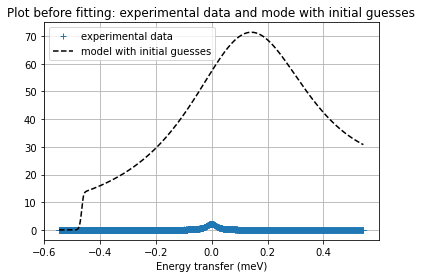

In [9]:
# Fit
result = gmodel.fit(yy, x=xx, scale1=1., center1=0., hwhm1=0.25, scale2=1., center2=1., hwhm2=0.25)

fig1, ax1 = plt.subplots()
ax1.plot(xx, yy, '+', label='experimental data')
ax1.plot(xx, result.init_fit, 'k--', label='model with initial guesses')
ax1.legend()
ax1.set(xlabel='Energy transfer (meV)', title='Plot before fitting: experimental data and mode with initial guesses')
ax1.grid();

## Plotting results

Result of fit:
 [[Model]]
    (Model(irf_gate) <function convolve at 0x7fcb20bc7e50> Model(model_2lorentzians))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 400
    # data points      = 1905
    # variables        = 6
    chi-square         = 0.68145871
    reduced chi-square = 3.5885e-04
    Akaike info crit   = -15105.6169
    Bayesian info crit = -15072.3035
[[Variables]]
    scale1:   0.00246457 +/- 4.7643e-06 (0.19%) (init = 1)
    center1: -0.12552370 +/- 3.3464e-05 (0.03%) (init = 0)
    hwhm1:    0.01640972 +/- 5.2875e-05 (0.32%) (init = 0.25)
    scale2:  -524.017817 +/- 75911185.2 (14486374.85%) (init = 1)
    center2: -13488.0110 +/- 8445968.06 (62618.34%) (init = 1)
    hwhm2:   -496.881610 +/- 71096638.8 (14308567.16%) (init = 0.25)
[[Correlations]] (unreported correlations are < 0.100)
    C(scale2, hwhm2)   = -1.000
    C(scale1, hwhm1)   = 0.763
    C(scale2, center2) = 0.619
    C(center2, hwhm2)  = -0.614
    C(hwhm1, scale2)   = 0.134


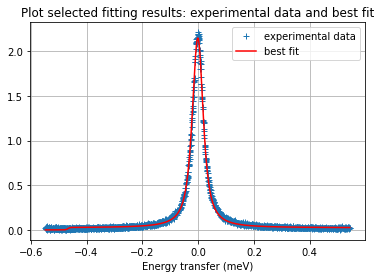

In [10]:
# display result
print('Result of fit:\n', result.fit_report())

# plot selected results: experimental data and best fit
fig2, ax2 = plt.subplots()
ax2.plot(xx, yy, '+', label='experimental data')
ax2.plot(xx, result.best_fit, 'r-', label='best fit')
ax2.grid()
ax2.set(xlabel='Energy transfer (meV)', title='Plot selected fitting results: experimental data and best fit')
ax2.legend();

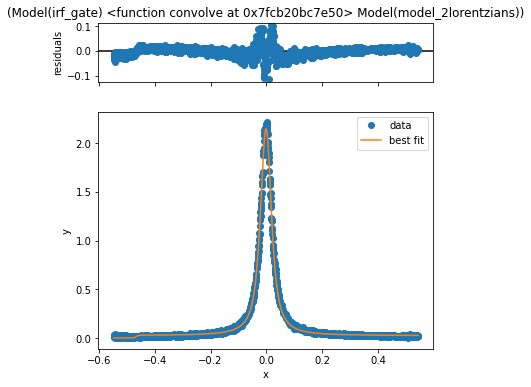

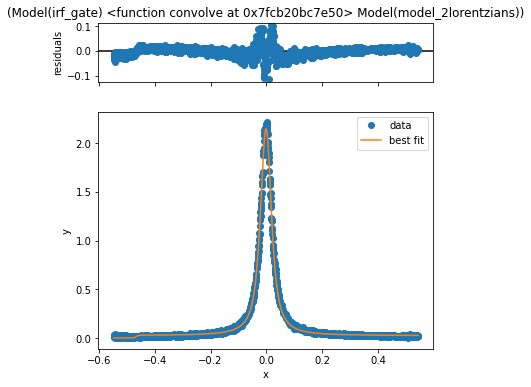

In [11]:
# other option to plot result using lmfit's features
result.plot()

In [12]:
for item in result.params.keys():
    print(item[:-1], result.params[item].value, '+/-', result.params[item].stderr, dict_physical_units[item[:-1]])

scale 0.0024645705170254924 +/- 4.764290117681272e-06 unit_of_signal.meV
center -0.125523697841406 +/- 3.346424555125187e-05 meV
hwhm 0.016409716500591233 +/- 5.2875039541799554e-05 meV
scale -524.0178166705638 +/- 75911185.199281 unit_of_signal.meV
center -13488.011007811288 +/- 8445968.060346557 meV
hwhm -496.8816095962389 +/- 71096638.80003688 meV
